In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec 14 15:34:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')
ROOT = "/content/gdrive/My Drive/"

Mounted at /content/gdrive


In [4]:
import os
import cv2
from PIL import Image
import tensorflow as tf
from keras import backend as K
from keras.models import load_model
from keras_preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
!cp "/content/gdrive/MyDrive/FAI/TrainTestVal.zip" /content  #Move File from Drive to Colab
!unzip -q "/content/gdrive/MyDrive/FAI/TrainTestVal.zip" -d /content #Unzip

In [6]:
!unzip -q "/content/gdrive/MyDrive/FAI/TrainTestVal.zip" -d /content #Unzip


In [7]:
train_normal = len(os.listdir("/content/TrainTestVal/Train/Tumor/"))
train_tumor = len(os.listdir("/content/TrainTestVal/Train/Normal/"))
print(train_normal)
print(train_tumor)
num_train = train_normal + train_tumor

test_normal = len(os.listdir("/content/TrainTestVal/Test/Tumor/"))
test_tumor = len(os.listdir("/content/TrainTestVal/Test/Normal/"))
print(test_normal)
print(test_tumor)
num_test = test_normal + test_tumor

val_normal = len(os.listdir("/content/TrainTestVal/Val/Tumor/"))
val_tumor = len(os.listdir("/content/TrainTestVal/Val/Normal/"))
print(val_normal)
print(val_tumor)
num_val = val_normal + val_tumor

4881
3258
611
408
610
407


In [8]:
img_dimensions  = 224
batch_size = 128

train = "/content/TrainTestVal/Train/"
test = "/content/TrainTestVal/Test/"
val = "/content/TrainTestVal/Val/"

In [ ]:
image_gen_train = ImageDataGenerator(rescale = 1./255)
train_data_gen = image_gen_train.flow_from_directory(directory = train, batch_size = batch_size,
shuffle= True, target_size = (img_dimensions,img_dimensions), class_mode = 'binary')

Found 8139 images belonging to 2 classes.


In [ ]:
image_gen_test = ImageDataGenerator(rescale = 1./255)
test_data_gen = image_gen_test.flow_from_directory(directory = test, batch_size = batch_size,
shuffle= True, target_size = (img_dimensions,img_dimensions), class_mode = 'binary')

Found 1019 images belonging to 2 classes.


In [ ]:
image_gen_val = ImageDataGenerator(rescale = 1./255)
val_data_gen = image_gen_train.flow_from_directory(directory = val, batch_size = batch_size,
shuffle= True, target_size = (img_dimensions,img_dimensions), class_mode = 'binary')

Found 1017 images belonging to 2 classes.


In [ ]:
pre_trained_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3),
                                                include_top=False, weights="imagenet")

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
for layer in pre_trained_model.layers:
  print(layer.name)
  layer.trainable = False

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [ ]:
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(2, activation='sigmoid')(x)


# strange
# 

In [ ]:
model = tf.keras.Model(pre_trained_model.input, x)
model.compile(optimizer='adam', 
              loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['acc'])


In [ ]:
model2 = tf.keras.Model(pre_trained_model.input, x)

model2.compile(optimizer='adam', 
              loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['acc'])

In [ ]:
batch_size = 64
history = model.fit(train_data_gen,
steps_per_epoch=(num_train//batch_size),
epochs = 50,
validation_data=val_data_gen,
validation_steps=(num_val//batch_size),
batch_size = batch_size,
verbose = 1)

In [ ]:
batch_size = 128
history2 = model2.fit_generator(train_data_gen,
steps_per_epoch=len(train_data_gen),
epochs = 20,
validation_data=val_data_gen,
validation_steps=len(val_data_gen),
verbose = 1)

Epoch 1/20
64/64 [==============================] - 44s 677ms/step - loss: 0.0455 - acc: 0.9828 - val_loss: 0.1200 - val_acc: 0.9636
Epoch 2/20
64/64 [==============================] - 45s 703ms/step - loss: 0.0472 - acc: 0.9823 - val_loss: 0.1139 - val_acc: 0.9587
Epoch 3/20
64/64 [==============================] - 47s 733ms/step - loss: 0.0495 - acc: 0.9817 - val_loss: 0.1105 - val_acc: 0.9626
Epoch 4/20
64/64 [==============================] - 47s 730ms/step - loss: 0.0462 - acc: 0.9832 - val_loss: 0.1242 - val_acc: 0.9558
Epoch 5/20
64/64 [==============================] - 47s 735ms/step - loss: 0.0519 - acc: 0.9803 - val_loss: 0.1149 - val_acc: 0.9577
Epoch 6/20
64/64 [==============================] - 47s 733ms/step - loss: 0.0495 - acc: 0.9816 - val_loss: 0.1156 - val_acc: 0.9617
Epoch 7/20
64/64 [==============================] - 47s 733ms/step - loss: 0.0486 - acc: 0.9822 - val_loss: 0.1238 - val_acc: 0.9548
Epoch 8/20
64/64 [==============================] - 47s 733ms/step - 

In [ ]:
num_train//batch_size

63

In [ ]:
result = model.evaluate(test_data_gen,batch_size=batch_size)
print("test_loss, test accuracy",result)

32/32 [==============================] - 5s 144ms/step - loss: 0.1367 - acc: 0.9578
test_loss, test accuracy [0.13674940168857574, 0.9578017592430115]


In [ ]:
test_loss, test_acc = model.evaluate(test_data_gen, verbose=2)

32/32 - 5s - loss: 0.1367 - acc: 0.9578 - 5s/epoch - 147ms/step


In [ ]:
predictions = model2.predict(test_data_gen)

8/8 [==============================] - 18s 2s/step


In [ ]:
predictions

array([[7.8483507e-02, 8.9272726e-01],
       [4.1571497e-03, 9.9510694e-01],
       [9.9992907e-01, 5.6297918e-05],
       ...,
       [9.9865913e-01, 1.8053615e-03],
       [3.7046522e-02, 9.3197972e-01],
       [8.1739914e-01, 1.2171389e-01]], dtype=float32)

In [ ]:
predictedLabels = np.argmax(predictions, axis=1)
predictedLabels


array([1, 1, 0, ..., 0, 1, 0])

In [ ]:
len(test_data_gen.filenames)

1019

In [ ]:
print(test_data_gen.class_indices.keys())
print(test_data_gen.filenames)
print(test_data_gen.classes)

dict_keys(['Normal', 'Tumor'])
['Normal/DS1_T0_no0.jpg', 'Normal/DS1_T0_no1013.jpg', 'Normal/DS1_T0_no1020.jpg', 'Normal/DS1_T0_no1030.jpg', 'Normal/DS1_T0_no104.jpg', 'Normal/DS1_T0_no1057.jpg', 'Normal/DS1_T0_no1067.jpg', 'Normal/DS1_T0_no1072.jpg', 'Normal/DS1_T0_no1074.jpg', 'Normal/DS1_T0_no1085.jpg', 'Normal/DS1_T0_no1094.jpg', 'Normal/DS1_T0_no1120.jpg', 'Normal/DS1_T0_no1123.jpg', 'Normal/DS1_T0_no1124.jpg', 'Normal/DS1_T0_no114.jpg', 'Normal/DS1_T0_no1155.jpg', 'Normal/DS1_T0_no1164.jpg', 'Normal/DS1_T0_no1181.jpg', 'Normal/DS1_T0_no1198.jpg', 'Normal/DS1_T0_no1200.jpg', 'Normal/DS1_T0_no1208.jpg', 'Normal/DS1_T0_no1221.jpg', 'Normal/DS1_T0_no1231.jpg', 'Normal/DS1_T0_no1242.jpg', 'Normal/DS1_T0_no126.jpg', 'Normal/DS1_T0_no1261.jpg', 'Normal/DS1_T0_no1265.jpg', 'Normal/DS1_T0_no1269.jpg', 'Normal/DS1_T0_no127.jpg', 'Normal/DS1_T0_no1270.jpg', 'Normal/DS1_T0_no1272.jpg', 'Normal/DS1_T0_no1281.jpg', 'Normal/DS1_T0_no1282.jpg', 'Normal/DS1_T0_no1295.jpg', 'Normal/DS1_T0_no1308.j

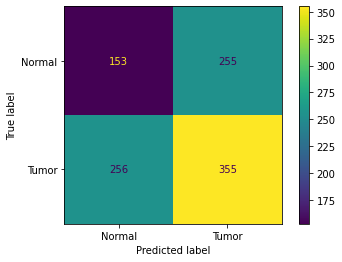

In [ ]:
cm = confusion_matrix(test_data_gen.classes, predictedLabels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=test_data_gen.class_indices.keys())

disp.plot()
plt.show()

In [ ]:
model_json = model.to_json()
with open("/content/gdrive/MyDrive/FAI/VGG_BrainTumorClassifier.json", "w") as json_file:
  json_file.write(model_json)
model.save("/content/gdrive/MyDrive/FAI/VGG_BrainTumorClassifier.h5")
print("Saved model to disk")
model.save_weights("/content/gdrive/MyDrive/FAI/VGG_BrainTumorClassifier_Weights.h5")

Saved model to disk


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import numpy as np
import pandas as pd
import random
import shutil

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [ ]:
def plot_diagnostics(history):
  plt.subplot(1,2,1)
  plt.title("Binary Cross Entropy Loss")
  plt.plot(history.history['loss'],color="blue",label="Train")
  plt.plot(history.history['val_loss'],color="red",label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.subplot(1,2,2)
  plt.title("Accuracy")
  plt.plot(history.history['acc'],color="blue",label="Train")
  plt.plot(history.history['val_acc'],color="red",label="Validation")
  plt.ylabel("% Accurate")
  plt.xlabel("Epoch")
  plt.legend()
  plt.show()


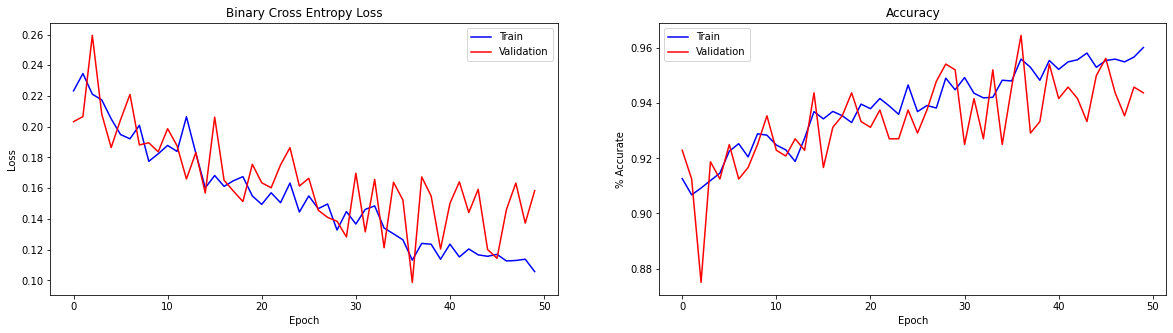

In [ ]:
plt.subplots(figsize=(20, 5))
plot_diagnostics(history)

In [ ]:
from sklearn.metrics import roc_curve
y_pred_keras = model2.predict(test_data_gen).ravel()
print(y_pred_keras)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_data_gen.classes, y_pred_keras)

8/8 [==============================] - 5s 633ms/step
[9.9047148e-01 9.6242754e-03 4.8745344e-05 ... 1.2327320e-04 4.6896827e-01
 4.9289989e-01]


ValueError: ignored

In [ ]:
#callback to stop the training if your validation accuracy is not increased in last 2 epochs
callback1 = EarlyStopping( monitor="val_accuracy",
                           patience=2,
                           verbose=1,
                           mode="auto",
                           min_delta=0 )

#callback to decay learning based on below conditions 
#Cond1. If validation accuracy at that epoch is less than previous epoch accuracy, decrease the learning rate by 10%. 
#Cond2. For every 3rd epoch, decay learning rate by 5%
#for Cond1:-
callback2 = ReduceLROnPlateau( monitor="val_accuracy",
                              factor=0.1,
                              patience=1,
                              verbose=1,
                              mode="auto"
                              )
#for Cond2:-
def lf_schedule(epoch,lr):
  if epoch%3 ==0:
    lr=lr - 0.05*lr #-->i.e. 0.95*lr (5% decay)
    print(f'New learning rate for epoch={epoch} is {lr}')
    return lr
  else:
    return lr
callback3 = LearningRateScheduler( schedule=lf_schedule,verbose=1 )

#callback to save the model at every epoch if validation accuracy is improved from previous epoch
#file path to save the best model for ModelCheckPoint:-
!mkdir "model_save/"
f_path = "model_save/best_model.h5"
callback4 = ModelCheckpoint( filepath=f_path,
                             monitor="val_accuracy",
                             verbose=1,
                             save_best_only=True,
                             mode="auto"
                           )

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
import math
import seaborn as sns
from tensorflow.keras.callbacks import Callback,ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,LearningRateScheduler
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from prettytable import PrettyTable

In [ ]:
# scaling the pixel values to the range 0-1 and augmenting:-

# creating the data generator (note: we'll augment the train data only. Not the test data)
datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
train_it = datagen.flow_from_directory(train,class_mode="binary",batch_size=64,target_size=(224,224))

# creating the data generator for validation set
validation_it = datagen.flow_from_directory(val,class_mode="binary",batch_size=64,target_size=(224,224))

# creating the data generator for test set
test_it = datagen.flow_from_directory(test,class_mode="binary",batch_size=64,target_size=(224,224))

# sanity
print("Checking the Binary Labels:-")
print(train_it.class_indices,validation_it.class_indices,test_it.class_indices)

print()
print("Our data pre-processing is now done!")


Found 8139 images belonging to 2 classes.
Found 1017 images belonging to 2 classes.
Found 1019 images belonging to 2 classes.
Checking the Binary Labels:-
{'Normal': 0, 'Tumor': 1} {'Normal': 0, 'Tumor': 1} {'Normal': 0, 'Tumor': 1}

Our data pre-processing is now done!


In [ ]:
def cnn_model4():
  # loading the base-model
  model=VGG16(include_top=False,input_shape=(224,224,3))
  # mark the loaded layers as not-trainable
  for layer in model.layers:
    layer.trainable=False
  # adding new classifier layers
  flat = Flatten()(model.layers[-1].output)
  classifier = Dense(units=128,activation='relu',kernel_initializer="he_uniform")(flat)
  output = Dense(units=1,activation="sigmoid")(classifier)
  # define the model
  model = Model(inputs=model.inputs,outputs=output)
  # compile the model
  model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
  return model

In [ ]:
model=cnn_model4()
history = model.fit_generator(generator=train_it,
                              steps_per_epoch=len(train_it),
                              validation_data=validation_it,
                              validation_steps=len(validation_it),
                              epochs=20,
                              callbacks=[callback1,callback2,callback3,callback4])

New learning rate for epoch=0 is 0.0009500000451225787

Epoch 1: LearningRateScheduler setting learning rate to 0.0009500000451225787.
Epoch 1/20
128/128 [==============================] - ETA: 0s - loss: 0.9853 - accuracy: 0.8922
Epoch 1: val_accuracy improved from -inf to 0.94494, saving model to model_save/best_model.h5
128/128 [==============================] - 52s 366ms/step - loss: 0.9853 - accuracy: 0.8922 - val_loss: 0.1315 - val_accuracy: 0.9449 - lr: 9.5000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 2/20
128/128 [==============================] - ETA: 0s - loss: 0.0712 - accuracy: 0.9749
Epoch 2: val_accuracy improved from 0.94494 to 0.95772, saving model to model_save/best_model.h5
128/128 [==============================] - 45s 350ms/step - loss: 0.0712 - accuracy: 0.9749 - val_loss: 0.1108 - val_accuracy: 0.9577 - lr: 9.5000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 3/20
128/128 [

In [ ]:
_,acc = model.evaluate_generator(generator=test_it,steps=len(test_it))
print("Evaluation Accuracy on test data-set=",np.round(acc*100,3),"%")

Evaluation Accuracy on test data-set= 96.86 %


In [ ]:
print(test_it.class_indices.keys())
print(test_it.filenames)
print(test_it.classes)


dict_keys(['Normal', 'Tumor'])
['Normal/DS1_T0_no0.jpg', 'Normal/DS1_T0_no1013.jpg', 'Normal/DS1_T0_no1020.jpg', 'Normal/DS1_T0_no1030.jpg', 'Normal/DS1_T0_no104.jpg', 'Normal/DS1_T0_no1057.jpg', 'Normal/DS1_T0_no1067.jpg', 'Normal/DS1_T0_no1072.jpg', 'Normal/DS1_T0_no1074.jpg', 'Normal/DS1_T0_no1085.jpg', 'Normal/DS1_T0_no1094.jpg', 'Normal/DS1_T0_no1120.jpg', 'Normal/DS1_T0_no1123.jpg', 'Normal/DS1_T0_no1124.jpg', 'Normal/DS1_T0_no114.jpg', 'Normal/DS1_T0_no1155.jpg', 'Normal/DS1_T0_no1164.jpg', 'Normal/DS1_T0_no1181.jpg', 'Normal/DS1_T0_no1198.jpg', 'Normal/DS1_T0_no1200.jpg', 'Normal/DS1_T0_no1208.jpg', 'Normal/DS1_T0_no1221.jpg', 'Normal/DS1_T0_no1231.jpg', 'Normal/DS1_T0_no1242.jpg', 'Normal/DS1_T0_no126.jpg', 'Normal/DS1_T0_no1261.jpg', 'Normal/DS1_T0_no1265.jpg', 'Normal/DS1_T0_no1269.jpg', 'Normal/DS1_T0_no127.jpg', 'Normal/DS1_T0_no1270.jpg', 'Normal/DS1_T0_no1272.jpg', 'Normal/DS1_T0_no1281.jpg', 'Normal/DS1_T0_no1282.jpg', 'Normal/DS1_T0_no1295.jpg', 'Normal/DS1_T0_no1308.j

16/16 [==============================] - 5s 287ms/step
[[9.9991024e-01]
 [8.4762603e-01]
 [9.5230865e-01]
 ...
 [9.1510210e-06]
 [1.1439366e-03]
 [9.9999976e-01]]
[0 0 0 ... 0 0 0]


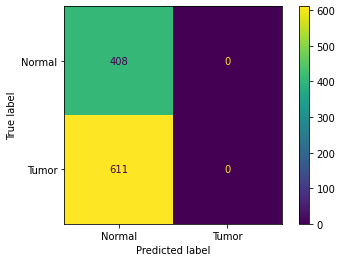

In [ ]:
predictions = model.predict(test_it)
print(predictions)
predictedLabels = np.argmax(predictions, axis=1)
print(predictedLabels)
cm = confusion_matrix(test_it.classes, predictedLabels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=test_it.class_indices.keys())

disp.plot()
plt.show()

In [ ]:
print(test_it.filepaths)

['/content/TrainTestVal/Test/Normal/DS1_T0_no0.jpg', '/content/TrainTestVal/Test/Normal/DS1_T0_no1013.jpg', '/content/TrainTestVal/Test/Normal/DS1_T0_no1020.jpg', '/content/TrainTestVal/Test/Normal/DS1_T0_no1030.jpg', '/content/TrainTestVal/Test/Normal/DS1_T0_no104.jpg', '/content/TrainTestVal/Test/Normal/DS1_T0_no1057.jpg', '/content/TrainTestVal/Test/Normal/DS1_T0_no1067.jpg', '/content/TrainTestVal/Test/Normal/DS1_T0_no1072.jpg', '/content/TrainTestVal/Test/Normal/DS1_T0_no1074.jpg', '/content/TrainTestVal/Test/Normal/DS1_T0_no1085.jpg', '/content/TrainTestVal/Test/Normal/DS1_T0_no1094.jpg', '/content/TrainTestVal/Test/Normal/DS1_T0_no1120.jpg', '/content/TrainTestVal/Test/Normal/DS1_T0_no1123.jpg', '/content/TrainTestVal/Test/Normal/DS1_T0_no1124.jpg', '/content/TrainTestVal/Test/Normal/DS1_T0_no114.jpg', '/content/TrainTestVal/Test/Normal/DS1_T0_no1155.jpg', '/content/TrainTestVal/Test/Normal/DS1_T0_no1164.jpg', '/content/TrainTestVal/Test/Normal/DS1_T0_no1181.jpg', '/content/Trai

In [20]:
def predict_tumor(img_path):
    # load the image
    img = load_img(img_path,target_size=(224,224))
    # convert to array
    img = img_to_array(img)/255
    img_array = np.array([img])
    plt.imshow(img_array[0])
    plt.show()
    best = load_model("model_save/best_model.h5")
    print(best.predict(img_array))
    if best.predict(img_array)[0][0]>0.4:
        print("The image indicates presence of Brain tumor")
    else:
        print("This is a Healthy Brain")
    print(best.predict(img_array)[0][0])

Normal/DS1_T0_no305.jpg
0


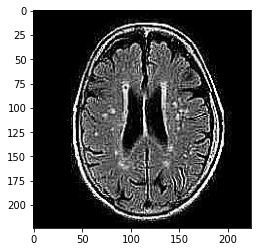

1/1 [==============================] - 0s 132ms/step
[[0.5035338]]
1/1 [==============================] - 0s 16ms/step
The image indicates presence of Brain tumor
1/1 [==============================] - 0s 18ms/step
0.5035338


In [ ]:
print(test_it.filenames[70])
print(test_it.classes[70])

predict_tumor(test_it.filepaths[70])

In [27]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [11]:
image_size = [224,224]
vgg = VGG16(input_shape= image_size+[3],weights='imagenet',include_top=False)


58889256/58889256 [==============================] - 3s 0us/step


In [13]:
x = vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = Dense(1024,activation='relu')(x)
x = Dense(512, activation='relu')(x)
preds = Dense(2,activation='softmax')(x)
model = Model(inputs = vgg.input,outputs=preds)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
for layer in vgg.layers:
    layer.trainable = False

In [15]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory(train, # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)


Found 8139 images belonging to 2 classes.


In [19]:
test_generator=train_datagen.flow_from_directory(test, # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical')

Found 1019 images belonging to 2 classes.


In [17]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
step_size_train=train_generator.n//train_generator.batch_size
r = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=5)

<ipython-input-18-9e570a6c20b9>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(generator=train_generator,


Epoch 1/5
254/254 [==============================] - 53s 168ms/step - loss: 0.4007 - accuracy: 0.8849
Epoch 2/5
254/254 [==============================] - 40s 159ms/step - loss: 0.1496 - accuracy: 0.9420
Epoch 3/5
254/254 [==============================] - 41s 162ms/step - loss: 0.1129 - accuracy: 0.9587
Epoch 4/5
254/254 [==============================] - 41s 160ms/step - loss: 0.0857 - accuracy: 0.9679
Epoch 5/5
254/254 [==============================] - 41s 160ms/step - loss: 0.0761 - accuracy: 0.9731


32/32 [==============================] - 5s 161ms/step
[[1.6838951e-06 9.9999833e-01]
 [8.6419624e-01 1.3580370e-01]
 [8.3625931e-01 1.6374071e-01]
 ...
 [1.6874527e-06 9.9999833e-01]
 [1.0537191e-06 9.9999893e-01]
 [2.8475411e-05 9.9997151e-01]]
[1 0 0 ... 1 1 1]


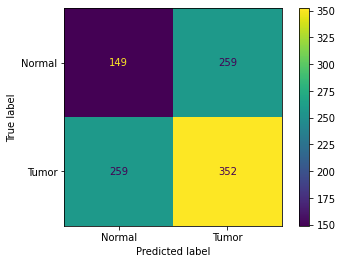

In [28]:
predictions = model.predict(test_generator)
print(predictions)
predictedLabels = np.argmax(predictions, axis=1)
print(predictedLabels)
cm = confusion_matrix(test_generator.classes, predictedLabels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=test_generator.class_indices.keys())

disp.plot()
plt.show()

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array

def predict_tumor(img_path):
    # load the image
    img = load_img(img_path,target_size=(224,224))
    # convert to array
    img = img_to_array(img)/255
    img_array = np.array([img])
    plt.imshow(img_array[0])
    plt.show()
    #best = load_model("model_save/best_model.h5")
    print(model.predict(img_array))
    if model.predict(img_array)[0][0]>0.4:
        print("The image indicates presence of Brain tumor")
    else:
        print("This is a Healthy Brain")
    print(model.predict(img_array)[0][0])

Tumor/DS2_T1_C2_m2 (106).jpg
1


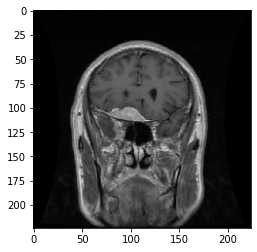

1/1 [==============================] - 0s 16ms/step
[[0.13012369 0.8698763 ]]
1/1 [==============================] - 0s 17ms/step
This is a Healthy Brain
1/1 [==============================] - 0s 16ms/step
0.13012369


In [25]:
print(test_generator.filenames[700])
print(test_generator.classes[700])

predict_tumor(test_generator.filepaths[700])